# Batch Reactor Example
## Ignition delay computation

In this example we will illustrate how to setup and use a constant volume batch reactor. This reactor will then be used to compute the ignition delay of a gas at any temperature and pressure

The reactor (system) is simply an insulated box.

In [1]:
from __future__ import division
from __future__ import print_function

import pandas as pd
import numpy as np

import cantera as ct
print('Runnning Cantera version: ' + ct.__version__)

Runnning Cantera version: 2.3.0a3


### Define the gas
In this example we will choose n-heptane as the gas. So we use the 160 species mechanism by Seier et al. 2000, Proc. Comb. Inst

In [2]:
gas = ct.Solution('data/seiser.cti')



**** WARNING ****
For species c7h15o-1, discontinuity in cp/R detected at Tmid = 1391
	Value computed using low-temperature polynomial:  53.0168
	Value computed using high-temperature polynomial: 52.748


**** WARNING ****
For species c7h15o-1, discontinuity in h/RT detected at Tmid = 1391
	Value computed using low-temperature polynomial:  21.8343
	Value computed using high-temperature polynomial: 21.767


### Define reactor conditions : temperature, pressure, fuel, stoichiometry

In [3]:
# Define the reactor temperature and pressure
reactorTemperature = 1000 #Kelvin
reactorPressure = 101325.0 #Pascals

gas.TP = reactorTemperature, reactorPressure

# Define the fuel, oxidizer and set the stoichiometry
gas.set_equivalence_ratio(phi=1.0, fuel='nc7h16', oxidizer={'o2':1.0, 'n2':3.76})

# Create a batch reactor object and add it to a reactor network
# In this example, the batch reactor will be the only reactor
# in the network
r = ct.IdealGasReactor(contents=gas, name='Batch Reactor')
reactorNetwork = ct.ReactorNet([r])

# now initialize an empty data frame into which we store values
# for this list all the species and turn them into column names
nSpecies = gas.n_species
stateVariables = nSpecies + 3

stateVariableNames = []
for i in range(stateVariables):
    stateVariableNames.append(r.component_name(i))


timeHistory = pd.DataFrame(columns=['time'] + stateVariableNames)

### Define useful functions

In [4]:
def updateStateDataFrame(df, stateArray):
    """
    This function will be used to store all the state variable parameters
    as the reactor evolves over time. At every time-step we call on this 
    function to update the dataFrame
    """
    return df.append(pd.DataFrame([stateArray], columns=df.columns), ignore_index=True)

def ignitionDelay(df, specie):
    """
    This function computes the ignition delay from the occurence of the 
    peak 'OH' value.
    """
    return df[specie].argmax(), df.iloc[df[specie].argmax()]['time']

In [5]:
timeStep=1e-4
simulationEndTime = 0.05
    
times = np.arange(0, simulationEndTime, timeStep)

for t in times:    
    reactorNetwork.advance(t)
    timeHistory = updateStateDataFrame(timeHistory, np.append(t, reactorNetwork.get_state()))

index, tau = ignitionDelay(timeHistory, 'oh')
print('Computed Ignition Delay: {} seconds'.format(tau))

Computed Ignition Delay: 0.0325 seconds


## Plot the result

### Import modules and set plotting defaults

In [6]:
import matplotlib.pylab as plt
%matplotlib notebook

plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.autolayout'] = True

plt.style.use('ggplot')
plt.style.use('seaborn-pastel')

### Plot illustrating the definition of ignition delay

<IPython.core.display.Javascript object>


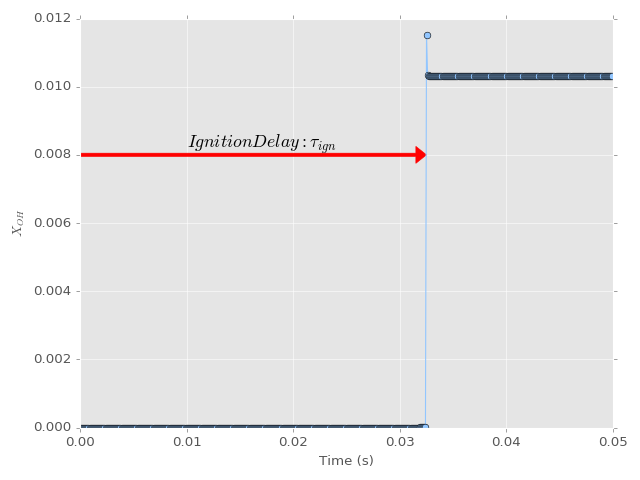

In [7]:
plt.plot(timeHistory['time'], timeHistory['oh'],'-o')
plt.xlabel('Time (s)')
plt.ylabel('$X_{OH}$')
plt.arrow(0, 0.008, tau, 0, width=0.0001, head_width=0.0005, 
          head_length=0.001, length_includes_head=True, color='r', shape='full')
plt.annotate(r'$Ignition Delay: \tau_{ign}$', xy=(0,0), xytext=(0.01, 0.0082), fontsize=16);

## Illustration : NTC behavior
One of the most common benchmarks of a reaction mechanism is its ability to reproduce the NTC behavior. This is done by computing and visualizing the ignition delay for a wide range of temperatures

### Define the temperatures for which we will run the simulations

In [8]:
# Make a list of all the temperatures we would like to run simulations at
T = [1800, 1600, 1400, 1200, 1000, 950, 925, 900, 850, 825, 800, 
     750, 700, 675, 650, 625, 612.25, 550, 500]

timeSteps = np.ones(len(T))*1e-3

# Make time step adjustments for the highest and lowest temperatures
timeSteps[:5] = [1e-7, 1e-7, 1e-6, 1e-5, 1e-4]
timeSteps[-2] = 1e-2
timeSteps[-1] = 1e-1

# Now create a dataFrame out of these
ignitionDelays = pd.DataFrame(data={'T':T})
ignitionDelays['ignDelay'] = np.nan

Now, what we will do is simply run the code prior to the plots for each temperature. This may not be the most efficient way of doing things; but the goal here is to provide a pedagogical example

In [9]:
for i, temperature in enumerate(T):

    # Setup the gas and reactor
    reactorTemperature = temperature
    reactorPressure = 101325.0 
    gas.TP = reactorTemperature, reactorPressure
    gas.set_equivalence_ratio(phi=1.0, fuel='nc7h16', oxidizer={'o2':1.0, 'n2':3.76})
    r = ct.IdealGasReactor(contents=gas, name='Batch Reactor')
    reactorNetwork = ct.ReactorNet([r])

    # Create and empty data frame
    timeHistory = pd.DataFrame(columns=timeHistory.columns)
    
    timeStep = timeSteps[i]
    simulationEndTime = timeStep*1000
    
    times = np.arange(0, simulationEndTime, timeStep)
    for t in times:    
        reactorNetwork.advance(t)
        timeHistory = updateStateDataFrame(timeHistory, np.append(t, reactorNetwork.get_state()))

    index, tau = ignitionDelay(timeHistory, 'oh')
    print('Computed Ignition Delay: {} seconds for T={}K'.format(tau, temperature))
    
    ignitionDelays.set_value(index=i, col='ignDelay', value=tau)

Computed Ignition Delay: 1.8e-05 seconds for T=1800K
Computed Ignition Delay: 3.52e-05 seconds for T=1600K
Computed Ignition Delay: 0.000161 seconds for T=1400K
Computed Ignition Delay: 0.00163 seconds for T=1200K
Computed Ignition Delay: 0.0325 seconds for T=1000K
Computed Ignition Delay: 0.08 seconds for T=950K
Computed Ignition Delay: 0.126 seconds for T=925K
Computed Ignition Delay: 0.201 seconds for T=900K
Computed Ignition Delay: 0.427 seconds for T=850K
Computed Ignition Delay: 0.473 seconds for T=825K
Computed Ignition Delay: 0.38 seconds for T=800K
Computed Ignition Delay: 0.155 seconds for T=750K
Computed Ignition Delay: 0.066 seconds for T=700K
Computed Ignition Delay: 0.058 seconds for T=675K
Computed Ignition Delay: 0.079 seconds for T=650K
Computed Ignition Delay: 0.154 seconds for T=625K
Computed Ignition Delay: 0.235 seconds for T=612.25K
Computed Ignition Delay: 3.82 seconds for T=550K
Computed Ignition Delay: 99.9 seconds for T=500K


<IPython.core.display.Javascript object>


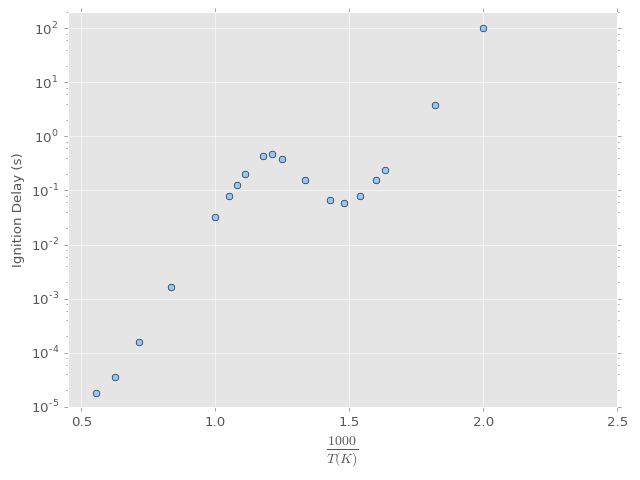

In [10]:
plt.figure()
plt.semilogy(1000/ignitionDelays['T'], ignitionDelays['ignDelay'],'o')

plt.ylim([1e-5, 200])
plt.xlim([0.45, 2.5])

plt.ylabel('Ignition Delay (s)')
plt.xlabel(r'$\frac{1000}{T (K)}$', fontsize=18);